In [5]:
from keras import layers, models
from keras import initializers , preprocessing, utils
import numpy as np
import re
import math
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Alphabet
# "abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
letters = "abcdefghijklmnopqrstuvwxyz"
numbers = "0123456789"
other_char = ",;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}" # original: -,;.!?:’’’/\|_@#$%ˆ&* ̃‘+-=<>()[]{}, changed: -,;.!?:’/\|_@#$%ˆ&* ̃‘+-=<>()[]{}
new_line = "\n"

alphabet = letters + numbers + other_char + new_line
print(alphabet)
print(len(alphabet))

abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'"/\|_@#$%^&*~`+-=<>()[]{}

69


In [3]:
# type of text
# __label__2 This is my first PDA/Organizer: I purchased this about 4 months ago and it really is easy to use especially if you are familiar with Microsoft Word and Excel. I use it to copy files from my PC that I want to have handy. The only thing I wish it had is a backlight. But that hasn't come into play too often. I usually have to charge it every 2 or 3 days. I recommend this product if you are not worried about having a lot accessories to go with it, because they are not that many available.
# __label__1 Piece of Crap: I have ordered thousands of items in my lifetime, and bar none, this is the biggest piece of crap I have ever received. It is supposed to come completely put together, but when it arrived, there were no less than 10 little parts that had come off the screen assembly and one screen that was loose and all of its parts dangling. The first thing that happenned is that I cut myself on one of the screens because the protective side had come off. I was bleeding for quite some time. The second thing I noticed was the extremely poor quality of the material and assembly. I am very handy by nature, but even I had to give up trying to put this piece of junk back together again. Plus it was not worth it, even if I had put it together again, all I would have then had was a piece of crap fireplace screen.
# data from  https://www.kaggle.com/bittlingmayer/amazonreviews

dir_name = './data/'
test_file_name = 'test.ft.txt'
train_file_name = 'train.ft.txt'


def getListOfLabelsAndLinesFromFile(file_name): # label 1 = 0, label 2 = 1
    
    labels = []
    lines = []
    total_labels = []
    count = 0
    file = open(file_name, 'r')
    for line in file:
        match = re.match('(__label__([0-9])) (.*)', line)
        if match:
            label = int(match.group(2)) - 1 # to make the label start in 0 (ZERO)
            text = match.group(3)
            if not label in total_labels: total_labels.append(label)
            labels.append(label)
            lines.append(text)
        else:
            print('---- ERROR ----')
        count += 1
    file.close()
    return { 'labels': labels, 'lines': lines, 'total_labels': total_labels, 'total_lines': count }

train_data_info = getListOfLabelsAndLinesFromFile(dir_name + train_file_name)
test_data_info = getListOfLabelsAndLinesFromFile(dir_name + test_file_name)

print(test_data_info['total_lines'])
print(train_data_info['total_lines'])
# ratio 9 

400000
3600000


In [4]:
# Constants
# Embedding
max_len_text = 1014
max_features_for_embedding = len(alphabet)
output_from_embedding = 128

# Large Model
initializer_large = { 'mean': 0.0, 'stddev': 0.02}
activation_conv = 'relu'
conv_output_dim = 256
pool_size = 3
kernel_size_7 = 7 # first_WITH_maxpool
kernel_size_3 = 3 # intermediate_NO_maxpool

# Small model
initializer_small = { 'mean': 0.0, 'stddev': 0.05}
activation_dens = 'relu'
dropout_rate = 0.5

In [5]:
# Create Model
# https://medium.com/@romannempyre/sentiment-analysis-using-1d-convolutional-neural-networks-part-1-f8b6316489a2
# https://github.com/chaitjo/character-level-cnn
# https://missinglink.ai/guides/deep-learning-frameworks/keras-conv1d-working-1d-convolutional-neural-networks-keras/
# https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf?gi=5c4a324fc922
# https://medium.com/@bramblexu/character-level-cnn-with-keras-50391c3adf33

model = models.Sequential() 

#model.add(layers.Input(shape=(max_len_text,),  dtype='int32'))

# AS the one hot approach, leave us with a very sparse and high dimensional matrix, we apply embedding
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
# Embedding ( 
#    max_features/input_dim = we got just 70 different types of inputs / Size of the vocabulary, 
#    output_dim = learn N dimensional embeddings for each of the input_dim words/characters,
#    input_length needed to flatten = cut the words/characters of each element to that lenght so the max
#                                     qty of elements in each phrase will be that one
# )    
model.add(layers.Embedding(max_features_for_embedding, output_from_embedding, input_length=max_len_text))
# After the Embedding layer,
# our activations have shape `(samples, maxlen, 8)`.
# Output: (batch dimension, input_length, output_dim)

# Convolutional Layer 1D
# In text 
# Conv1D(
#    filters = dimensionality of the output space
#    kernel_size = window_size
#    stride = position jumps of the window (defaults to 1)
# )
initializer_large_model = initializers.RandomNormal(mean=0.0, stddev=0.02, seed=None)
model.add(layers.Conv1D(filters=conv_output_dim, kernel_size=kernel_size_7, activation=activation_conv, kernel_initializer=initializer_large_model))

# Max Pooling 1D
# MaxPool1D(
#    pool_size = window size
#    strides = by default equals pool_size, so each window doesn't overlap
# )
model.add(layers.MaxPool1D(pool_size=pool_size))
model.add(layers.Conv1D(filters=conv_output_dim, kernel_size=kernel_size_7, activation=activation_conv))
model.add(layers.MaxPool1D(pool_size=pool_size))
model.add(layers.Conv1D(filters=conv_output_dim, kernel_size=kernel_size_3, activation=activation_conv))
model.add(layers.Conv1D(filters=conv_output_dim, kernel_size=kernel_size_3, activation=activation_conv))
model.add(layers.Conv1D(filters=conv_output_dim, kernel_size=kernel_size_3, activation=activation_conv))
model.add(layers.Conv1D(filters=conv_output_dim, kernel_size=kernel_size_3, activation=activation_conv))
model.add(layers.MaxPool1D(pool_size=pool_size))

# Second part, full connected layers
initializer_small_model = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation=activation_dens, kernel_initializer=initializer_small_model))
model.add(layers.Dropout(dropout_rate))
model.add(layers.Dense(1024, activation=activation_dens))
model.add(layers.Dropout(dropout_rate))

# Last layer, according to problem to solve
# (just have 2 classes)
# But, it has to be though a Dense(2,...) , with Dense(1,...) not working so neither do activation "sigmoid"
model.add(layers.Dense(2, activation='softmax')) 


model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1014, 128)         8832      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1008, 256)         229632    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 336, 256)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 330, 256)          459008    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 110, 256)          0         
_________________________________________________________________
conv1d_3 (Conv1D)    

In [6]:
# add optimizer and loss function and metrics to return 
# binary_crossentropy ? 
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
def getAlphabetDict(alpha):
    d = {}; c = 1
    for a in alpha: d[a] = c; c += 1
    return d

In [8]:
def getDataAndClasses(tokenizer, info, alpha, max_len_text, batch_len = None, from_i = 0):
        
    lines = info['lines']
    labels = info['labels']
    if batch_len != None: 
        lines = lines[from_i:(from_i + batch_len)]
        labels = labels[from_i:(from_i + batch_len)]
    
    sequences = tokenizer.texts_to_sequences(lines)
    """EX: [[15, 9, 2, 5, 3, 1, 13, 12, 28, 1, 14, 17 ...""" # Each, number represents a letter in the alphabet
    data = preprocessing.sequence.pad_sequences(sequences, maxlen=max_len_text, padding='post')
    # Data of shape (quantity of info (sentences), max_len_text)
    """EX: array([[15,  9,  2, ...,  0,  0,  0],
       [ 6,  8,  2, ...,  0,  0,  0],
       [21,  5,  3, ...,  0,  0,  0]], dtype=int32)"""  
    
    classes = utils.to_categorical(labels, num_classes=len(info['total_labels']))
    """EX: array([[0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)"""
    
    return {'data': data, 'classes': classes}

In [9]:
hist_arr = []
def runByBatches(model, train_info, test_info, alpha, max_len_text, batch_size, test_batch_size, until = None):
    
    # Preprocess Data 
    tokenizer = preprocessing.text.Tokenizer(char_level=True, lower=True, filters=alpha) # , oov_token= ?  
    tokenizer.word_index = getAlphabetDict(alpha)
    """EX: {'a': 1,
         'b': 2,
         'c': 3 ... """
    
    # After each epoch , the test data is validated
    # test_data = getDataAndClasses(tokenizer, test_info, alpha, max_len_text)
    test_data = getDataAndClasses(tokenizer, test_info, alpha, max_len_text, test_batch_size,0)
        
    total_train_len = train_info['total_lines']
    total_tst_len = test_info['total_lines']
    count = count_tst = 0
    
    while count < total_train_len and (until != None and count < until):
        
        # Get elements
        size = batch_size if batch_size < (total_train_len - count) else total_train_len - count
        size_tst = test_batch_size if test_batch_size < (total_tst_len - count_tst) else total_tst_len - count_tst
        train_data = getDataAndClasses(tokenizer, train_info, alpha, max_len_text, size, count)
        #test_data = getDataAndClasses(tokenizer, test_info, alpha, max_len_text, size_tst, count_tst)
        print(f'-----  doing from trining/test: {count} - {size + count}') # / {count_tst} - {size_tst}')
        count += batch_size   
        count_tst += test_batch_size
        
        history = model.fit(train_data['data'], 
                            train_data['classes'],
                            validation_data=(test_data['data'], test_data['classes']),
                            epochs=4, # 5000
                            batch_size=128,
                            verbose=2
                           )
        hist_arr.append(history.history)
        
        train_data = None
        #test_data = None

In [10]:
def getWindowOfBatchInArray(a, from_i, to_i):
    tot_len = len(a)
    until_pos = from_i + to_i
    remaining = 0
    if until_pos > tot_len: 
        remaining = until_pos - tot_len 
        return a[from_i:(tot_len + 1)]+a[0:remaining]
    else:
        return a[from_i:to_i]

In [11]:
test_batch_size = math.ceil(test_data_info['total_lines']/\
    (train_data_info['total_lines']/test_data_info['total_lines']))
test_size = 40000
train_size = 40000
n = 10
runByBatches(model, 
            train_data_info, 
            test_data_info, 
            alphabet, 
            max_len_text, 
            train_size, #test_data_info['total_lines'],
            test_size, # test batch size
            train_size * n # until n chunks of data (n repetitions)
           )


-----  doing from trining/test: 0 - 40000
Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 40000 samples
Epoch 1/4
 - 402s - loss: 0.6303 - acc: 0.6198 - val_loss: 0.4988 - val_acc: 0.7622
Epoch 2/4
 - 362s - loss: 0.4479 - acc: 0.7941 - val_loss: 0.4718 - val_acc: 0.7666
Epoch 3/4
 - 377s - loss: 0.3468 - acc: 0.8493 - val_loss: 0.3554 - val_acc: 0.8433
Epoch 4/4
 - 368s - loss: 0.2731 - acc: 0.8875 - val_loss: 0.3206 - val_acc: 0.8631
-----  doing from trining/test: 40000 - 80000
Train on 40000 samples, validate on 40000 samples
Epoch 1/4
 - 372s - loss: 0.3139 - acc: 0.8672 - val_loss: 0.3053 - val_acc: 0.8682
Epoch 2/4
 - 387s - loss: 0.2446 - acc: 0.9004 - val_loss: 0.3084 - val_acc: 0.8773
Epoch 3/4
 - 372s - loss: 0.1932 - acc: 0.9241 - val_loss: 0.3088 - val_acc: 0.8762
Epoch 4/4
 - 382s - loss: 0.1440 - acc: 0.9444 - val_loss: 0.3359 - val_acc: 0.8724
-----  doing from trining/test: 80000 - 120000
Train on 40000 samples, validate on 40000 sam

In [ ]:
"""tokenizer = preprocessing.text.Tokenizer(char_level=True, lower=True, filters=alphabet) # , oov_token= ?  
tokenizer.word_index = getAlphabetDict(alphabet)
t = getDataAndClasses(tokenizer, test_data_info, alphabet, max_len_text, 10000,0)"""

In [ ]:
"""hist_arr[0].history"""

In [28]:
def plotHistoryList(h, title = None, save = False, name = None):
    acc = h['acc']
    val_acc = h['val_acc']
    loss = h['loss']
    val_loss = h['val_loss']

    epochs = range(1, len(acc) + 1)
    
    fig, ax1 = plt.subplots()
    
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='r')
    ax1.scatter(epochs, loss, color='r')
    ax1.plot(epochs, val_loss, color='r')
    ax1.tick_params(axis='y', labelcolor='r')
    
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    
    ax2.set_ylabel('Accuracy', color='b')
    ax2.scatter(epochs, acc, color='b')
    ax2.plot(epochs, val_acc, color='b')
    ax2.tick_params(axis='y', labelcolor='b')
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    # normal plot
    """
    # "bo" is for "blue dot"
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, acc, 'ro', label='Accuracy')
    # b is for "solid blue line"
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    """
    if title != None: plt.title(title)
    if save and name != None: plt.savefig(name)
    
    plt.show()

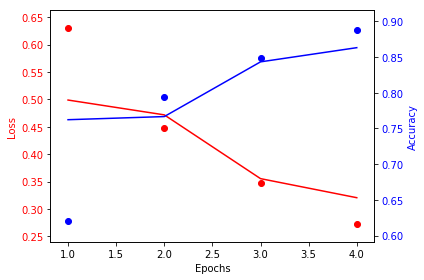

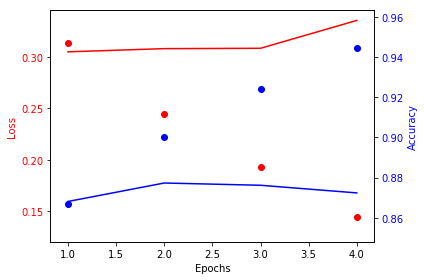

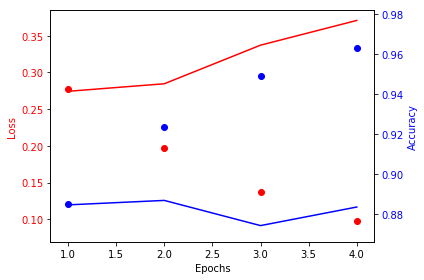

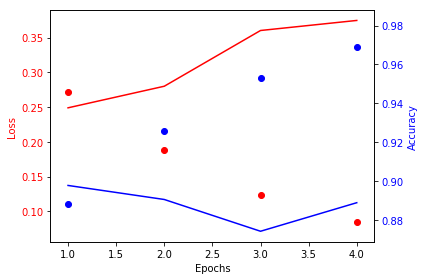

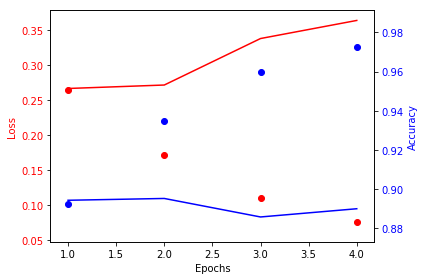

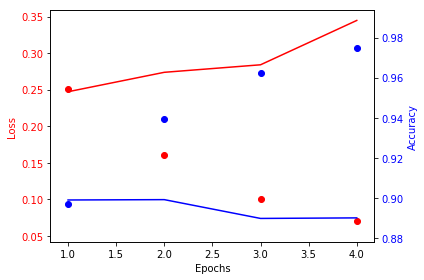

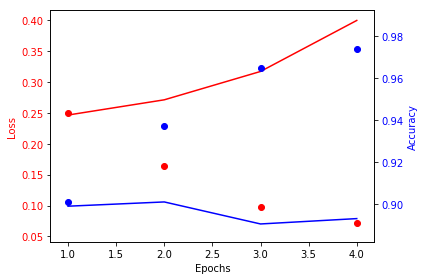

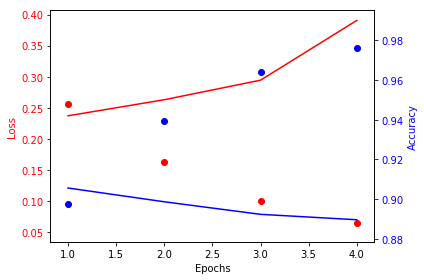

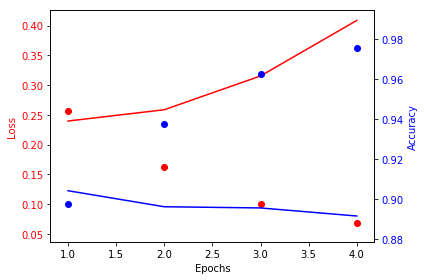

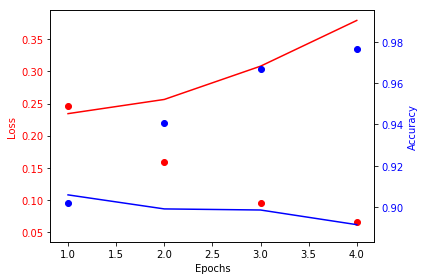

In [25]:
for h in hist_arr:
    plotHistoryList(h)

In [ ]:
# FROM FIRST TEST
"""
By using a sample data of 10000 each time, and 10000 for validation, 
it established that at epoch 3 it was enough since it started to have overfitting

[{'val_loss': [0.6950897953033447,
   0.6947383718490601,
   0.6934752422332764,
   0.6931729074478149,
   0.6935873050689697],
  'val_acc': [0.4875, 0.4875, 0.4875, 0.4875, 0.4875],
  'loss': [0.694396387386322,
   0.6932769330978393,
   0.6929676490783692,
   0.6933105537414551,
   0.6934012260437011],
  'acc': [0.5027, 0.51, 0.5084, 0.5055, 0.5029]},
 {'val_loss': [0.693684473323822,
   0.69328423204422,
   0.6938694007873535,
   0.693745785331726,
   0.693725270652771],
  'val_acc': [0.5125, 0.5125, 0.5125, 0.5125, 0.5125],
  'loss': [0.6909599201202392,
   0.6909819056510925,
   0.690941504573822,
   0.6910166868209839,
   0.6907023878097535],
  'acc': [0.5339, 0.5354, 0.5354, 0.5354, 0.5354]},
 {'val_loss': [0.6928669214248657,
   0.6928351986885071,
   0.6929179975509644,
   0.6928665622711182,
   0.6929092376708984],
  'val_acc': [0.5125, 0.5125, 0.5125, 0.5125, 0.5125],
  'loss': [0.6928800000190735,
   0.6927422769546508,
   0.692695544910431,
   0.6927323137283325,
   0.6927251628875732],
  'acc': [0.5171, 0.5172, 0.5171, 0.5171, 0.5157]}]

"""
# SECOND

"""
[{'val_loss': [0.6933708633422851,
   0.6928537891387939,
   0.692834661102295,
   0.6928840206146241,
   0.6929055606842041],
  'val_acc': [0.4875, 0.5125, 0.5125, 0.5125, 0.5125],
  'loss': [0.6934309574127198,
   0.6930742263793945,
   0.6930086311340332,
   0.6929674413681031,
   0.6930006246566772],
  'acc': [0.50965, 0.51025, 0.51005, 0.5117, 0.50945]},
 {'val_loss': [0.6928420051574707,
   0.6929439851760865,
   0.693077564239502,
   0.6930943966865539,
   0.6930167970657348],
  'val_acc': [0.5125, 0.5125, 0.5125, 0.5125, 0.5125],
  'loss': [0.6932257574081421,
   0.6932153765678406,
   0.6932126870155334,
   0.6931769281387329,
   0.693256987953186],
  'acc': [0.5025, 0.5051, 0.50615, 0.50025, 0.49795]}]
"""

# Third 30000 / 15000
"""
[{'val_loss': [0.6932847999890646,
   0.6933213699658711,
   0.6930976839383444,
   0.6931018094380696,
   0.6930792671521505],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6933522695223491,
   0.6929458774248759,
   0.6930164001146952,
   0.6929120743115743,
   0.6929684819221497],
  'acc': [0.5136000000158946,
   0.5124333333333333,
   0.5129666666984558,
   0.5137000000317892,
   0.5138333333651225]},
 {'val_loss': [0.6931314949353536,
   0.6930487598737081,
   0.6931946491559347,
   0.693049590587616,
   0.6932759721120199],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6929239110628764,
   0.6928764338493347,
   0.6929650987943013,
   0.6928932430585225,
   0.6928442873636882],
  'acc': [0.5129333333015442,
   0.5128,
   0.5133666666666666,
   0.5129999999841054,
   0.5129666666666667]}]
"""
# Fourth 100 000 / 15 000
"""
[{'val_loss': [0.6935770348866781,
   0.693049957370758,
   0.6931386842091878,
   0.6931923212369283,
   0.6930569999694824],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.693238242149353,
   0.6929247446441651,
   0.692936732673645,
   0.6928754871940613,
   0.6928619545555115],
  'acc': [0.5106, 0.512, 0.51234, 0.51267, 0.51267]}]
"""
# Fifth 20 000 / 15 000 (5 times)
"""
[{'val_loss': [0.6930875172615051,
   0.6930843497912089,
   0.6934041076978048,
   0.6935051878611247,
   0.6931250178019206],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6936674816131592,
   0.6930888975143432,
   0.6951768466949463,
   0.693067194366455,
   0.6930339816093445],
  'acc': [0.50965, 0.50625, 0.51175, 0.51125, 0.5125]},
 {'val_loss': [0.6931213233629863,
   0.6931330739021301,
   0.6930682267824809,
   0.693061719640096,
   0.6931284649848938],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6932584546089172,
   0.6931955748558044,
   0.6931753499984741,
   0.6931837162017822,
   0.6932215364456177],
  'acc': [0.5019, 0.50075, 0.50005, 0.50375, 0.5013]},
 {'val_loss': [0.6931777195930481,
   0.6935282015800476,
   0.6935493802388509,
   0.6932427165031433,
   0.6935413696289062],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6924584628105164,
   0.6921570532798768,
   0.6920773757934571,
   0.692116604423523,
   0.6921314051628112],
  'acc': [0.52205, 0.5237, 0.5237, 0.5237, 0.5237]},
 {'val_loss': [0.6931134839375814,
   0.6930499877929688,
   0.6930544673919677,
   0.6930453857421875,
   0.6930874656677246],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6930728750228882,
   0.692966617679596,
   0.6930215294837951,
   0.6930123390197754,
   0.6930175746917725],
  'acc': [0.50985, 0.5098, 0.50985, 0.50985, 0.5098]},
 {'val_loss': [0.693133440430959,
   0.6931064677874247,
   0.6930852600097657,
   0.6930747243245443,
   0.6930734438578288],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6928748257637024,
   0.6929110748291015,
   0.6928599676132202,
   0.6928945977210998,
   0.6928995547294616],
  'acc': [0.5126, 0.5126, 0.5126, 0.5126, 0.5126]}]
"""
# Sixth 40 000 test 40 000 train 10 repetitions
"""
[{'val_loss': [0.49881081466674804,
   0.4717710014820099,
   0.35536931228637697,
   0.3205692740917206],
  'val_acc': [0.762225, 0.766625, 0.843275, 0.86315],
  'loss': [0.6303098274230957,
   0.44791171159744264,
   0.3468285531997681,
   0.27311122870445254],
  'acc': [0.61975, 0.794125, 0.849325, 0.8875]},
 {'val_loss': [0.3053042756080627,
   0.308405194234848,
   0.308764573431015,
   0.3359229224443436],
  'val_acc': [0.868175, 0.87735, 0.876225, 0.872425],
  'loss': [0.3139024566650391,
   0.24463748073577882,
   0.19323326365947724,
   0.14400334199666978],
  'acc': [0.86715, 0.9004, 0.924075, 0.9444]},
 {'val_loss': [0.27427815690040586,
   0.28455733699798585,
   0.3371319869041443,
   0.370827214550972],
  'val_acc': [0.884575, 0.8868, 0.874225, 0.8835],
  'loss': [0.27802091131210327,
   0.196414630818367,
   0.13643594622612,
   0.09739455650448799],
  'acc': [0.8852, 0.9234, 0.94905, 0.96285]},
 {'val_loss': [0.24903032941818237,
   0.2800765148639679,
   0.36023315348625184,
   0.3746987383365631],
  'val_acc': [0.89795, 0.89075, 0.87445, 0.8891],
  'loss': [0.2717844838142395,
   0.18792205538749696,
   0.12372702569961548,
   0.08530010979473591],
  'acc': [0.88835, 0.925925, 0.9533, 0.9688]},
 {'val_loss': [0.26640101244449615,
   0.2713427514791489,
   0.3376887015104294,
   0.3635027582406998],
  'val_acc': [0.894275, 0.8952, 0.88575, 0.88995],
  'loss': [0.26361796135902404,
   0.17128136606216432,
   0.10989078753292561,
   0.07645529963374138],
  'acc': [0.89225, 0.934725, 0.9599, 0.9723]},
 {'val_loss': [0.24720766174793243,
   0.27378872973918916,
   0.28408009884357455,
   0.34479169399738313],
  'val_acc': [0.899, 0.899175, 0.8898, 0.890075],
  'loss': [0.2508507478237152,
   0.16069013158082962,
   0.10054244674444199,
   0.07001338513493538],
  'acc': [0.8972, 0.9392, 0.96255, 0.97475]},
 {'val_loss': [0.2465739718914032,
   0.27122063734531404,
   0.31714685039520263,
   0.3997681526184082],
  'val_acc': [0.89915, 0.901175, 0.8907, 0.89325],
  'loss': [0.2506037933111191,
   0.16453868765830992,
   0.09823134387135506,
   0.0721335696876049],
  'acc': [0.901025, 0.9374, 0.964775, 0.973725]},
 {'val_loss': [0.23710816338062288,
   0.2629594801664352,
   0.29442494423389437,
   0.39059445977211],
  'val_acc': [0.9056, 0.898675, 0.89235, 0.889625],
  'loss': [0.2562410287857056,
   0.16355337309837342,
   0.09930451941490173,
   0.06507483651936054],
  'acc': [0.897625, 0.939275, 0.964, 0.9762]},
 {'val_loss': [0.23953482286930083,
   0.2585186312675476,
   0.3152854981899261,
   0.4086348847866058],
  'val_acc': [0.904125, 0.896125, 0.895525, 0.8915],
  'loss': [0.25655409202575685,
   0.1626516498208046,
   0.10038786889314652,
   0.06800436522364617],
  'acc': [0.897675, 0.9375, 0.9625, 0.9754]},
 {'val_loss': [0.2342738193511963,
   0.2563602669239044,
   0.3081534208774567,
   0.3793575043439865],
  'val_acc': [0.9059, 0.8991, 0.898575, 0.891475],
  'loss': [0.24582136721611023,
   0.15862737138271332,
   0.09455530262589455,
   0.06496932366937398],
  'acc': [0.902075, 0.940575, 0.96665, 0.9766]}]
"""

In [1]:
hist_arr = [{'val_loss': [0.49881081466674804,
   0.4717710014820099,
   0.35536931228637697,
   0.3205692740917206],
  'val_acc': [0.762225, 0.766625, 0.843275, 0.86315],
  'loss': [0.6303098274230957,
   0.44791171159744264,
   0.3468285531997681,
   0.27311122870445254],
  'acc': [0.61975, 0.794125, 0.849325, 0.8875]},
 {'val_loss': [0.3053042756080627,
   0.308405194234848,
   0.308764573431015,
   0.3359229224443436],
  'val_acc': [0.868175, 0.87735, 0.876225, 0.872425],
  'loss': [0.3139024566650391,
   0.24463748073577882,
   0.19323326365947724,
   0.14400334199666978],
  'acc': [0.86715, 0.9004, 0.924075, 0.9444]},
 {'val_loss': [0.27427815690040586,
   0.28455733699798585,
   0.3371319869041443,
   0.370827214550972],
  'val_acc': [0.884575, 0.8868, 0.874225, 0.8835],
  'loss': [0.27802091131210327,
   0.196414630818367,
   0.13643594622612,
   0.09739455650448799],
  'acc': [0.8852, 0.9234, 0.94905, 0.96285]},
 {'val_loss': [0.24903032941818237,
   0.2800765148639679,
   0.36023315348625184,
   0.3746987383365631],
  'val_acc': [0.89795, 0.89075, 0.87445, 0.8891],
  'loss': [0.2717844838142395,
   0.18792205538749696,
   0.12372702569961548,
   0.08530010979473591],
  'acc': [0.88835, 0.925925, 0.9533, 0.9688]},
 {'val_loss': [0.26640101244449615,
   0.2713427514791489,
   0.3376887015104294,
   0.3635027582406998],
  'val_acc': [0.894275, 0.8952, 0.88575, 0.88995],
  'loss': [0.26361796135902404,
   0.17128136606216432,
   0.10989078753292561,
   0.07645529963374138],
  'acc': [0.89225, 0.934725, 0.9599, 0.9723]},
 {'val_loss': [0.24720766174793243,
   0.27378872973918916,
   0.28408009884357455,
   0.34479169399738313],
  'val_acc': [0.899, 0.899175, 0.8898, 0.890075],
  'loss': [0.2508507478237152,
   0.16069013158082962,
   0.10054244674444199,
   0.07001338513493538],
  'acc': [0.8972, 0.9392, 0.96255, 0.97475]},
 {'val_loss': [0.2465739718914032,
   0.27122063734531404,
   0.31714685039520263,
   0.3997681526184082],
  'val_acc': [0.89915, 0.901175, 0.8907, 0.89325],
  'loss': [0.2506037933111191,
   0.16453868765830992,
   0.09823134387135506,
   0.0721335696876049],
  'acc': [0.901025, 0.9374, 0.964775, 0.973725]},
 {'val_loss': [0.23710816338062288,
   0.2629594801664352,
   0.29442494423389437,
   0.39059445977211],
  'val_acc': [0.9056, 0.898675, 0.89235, 0.889625],
  'loss': [0.2562410287857056,
   0.16355337309837342,
   0.09930451941490173,
   0.06507483651936054],
  'acc': [0.897625, 0.939275, 0.964, 0.9762]},
 {'val_loss': [0.23953482286930083,
   0.2585186312675476,
   0.3152854981899261,
   0.4086348847866058],
  'val_acc': [0.904125, 0.896125, 0.895525, 0.8915],
  'loss': [0.25655409202575685,
   0.1626516498208046,
   0.10038786889314652,
   0.06800436522364617],
  'acc': [0.897675, 0.9375, 0.9625, 0.9754]},
 {'val_loss': [0.2342738193511963,
   0.2563602669239044,
   0.3081534208774567,
   0.3793575043439865],
  'val_acc': [0.9059, 0.8991, 0.898575, 0.891475],
  'loss': [0.24582136721611023,
   0.15862737138271332,
   0.09455530262589455,
   0.06496932366937398],
  'acc': [0.902075, 0.940575, 0.96665, 0.9766]}]

In [9]:
l = [2, 3, 4]
k = [5, 6, 7]
print(l + k)

[2, 3, 4, 5, 6, 7]


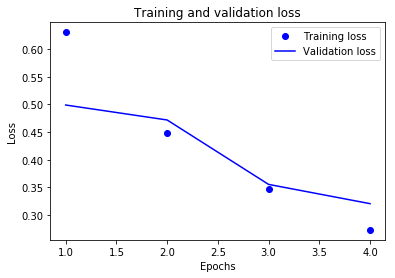

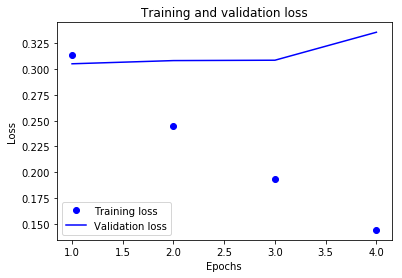

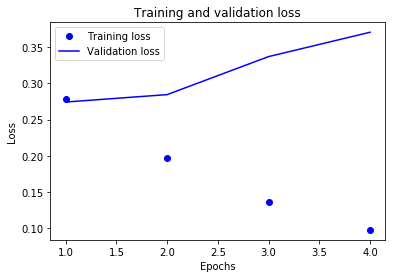

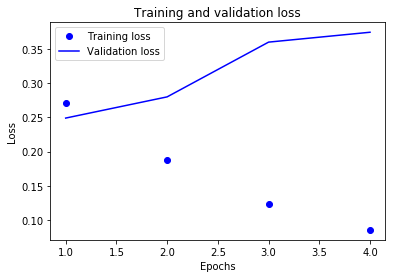

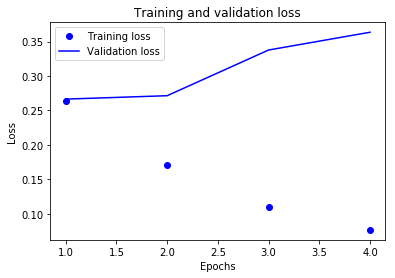

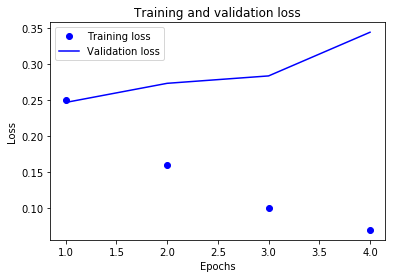

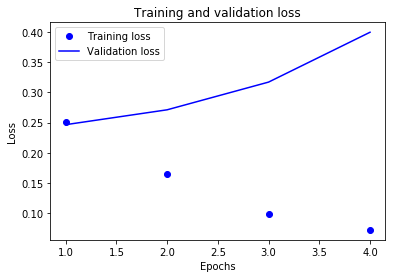

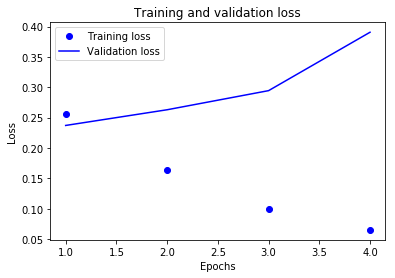

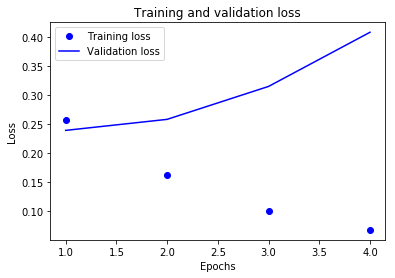

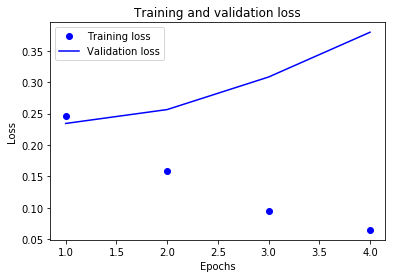

In [10]:
for h in hist_arr:
    plotHistoryList(h)    

In [11]:
def unifyHistories(h_arr):
    unify = {}
    unify['val_loss'] = []
    unify['val_acc'] = []
    unify['loss'] = []
    unify['acc'] = []
    for h in h_arr:
        unify['val_loss'] = unify['val_loss'] + h['val_loss']
        unify['val_acc'] = unify['val_acc'] + h['val_acc']
        unify['loss'] = unify['loss'] + h['loss']
        unify['acc'] = unify['acc'] + h['acc']
    return unify

In [12]:
h_1 = [{'val_loss': [0.6950897953033447,
   0.6947383718490601,
   0.6934752422332764,
   0.6931729074478149,
   0.6935873050689697],
  'val_acc': [0.4875, 0.4875, 0.4875, 0.4875, 0.4875],
  'loss': [0.694396387386322,
   0.6932769330978393,
   0.6929676490783692,
   0.6933105537414551,
   0.6934012260437011],
  'acc': [0.5027, 0.51, 0.5084, 0.5055, 0.5029]},
 {'val_loss': [0.693684473323822,
   0.69328423204422,
   0.6938694007873535,
   0.693745785331726,
   0.693725270652771],
  'val_acc': [0.5125, 0.5125, 0.5125, 0.5125, 0.5125],
  'loss': [0.6909599201202392,
   0.6909819056510925,
   0.690941504573822,
   0.6910166868209839,
   0.6907023878097535],
  'acc': [0.5339, 0.5354, 0.5354, 0.5354, 0.5354]},
 {'val_loss': [0.6928669214248657,
   0.6928351986885071,
   0.6929179975509644,
   0.6928665622711182,
   0.6929092376708984],
  'val_acc': [0.5125, 0.5125, 0.5125, 0.5125, 0.5125],
  'loss': [0.6928800000190735,
   0.6927422769546508,
   0.692695544910431,
   0.6927323137283325,
   0.6927251628875732],
  'acc': [0.5171, 0.5172, 0.5171, 0.5171, 0.5157]}]
h_2 = [{'val_loss': [0.6933708633422851,
   0.6928537891387939,
   0.692834661102295,
   0.6928840206146241,
   0.6929055606842041],
  'val_acc': [0.4875, 0.5125, 0.5125, 0.5125, 0.5125],
  'loss': [0.6934309574127198,
   0.6930742263793945,
   0.6930086311340332,
   0.6929674413681031,
   0.6930006246566772],
  'acc': [0.50965, 0.51025, 0.51005, 0.5117, 0.50945]},
 {'val_loss': [0.6928420051574707,
   0.6929439851760865,
   0.693077564239502,
   0.6930943966865539,
   0.6930167970657348],
  'val_acc': [0.5125, 0.5125, 0.5125, 0.5125, 0.5125],
  'loss': [0.6932257574081421,
   0.6932153765678406,
   0.6932126870155334,
   0.6931769281387329,
   0.693256987953186],
  'acc': [0.5025, 0.5051, 0.50615, 0.50025, 0.49795]}]
h_3 = [{'val_loss': [0.6932847999890646,
   0.6933213699658711,
   0.6930976839383444,
   0.6931018094380696,
   0.6930792671521505],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6933522695223491,
   0.6929458774248759,
   0.6930164001146952,
   0.6929120743115743,
   0.6929684819221497],
  'acc': [0.5136000000158946,
   0.5124333333333333,
   0.5129666666984558,
   0.5137000000317892,
   0.5138333333651225]},
 {'val_loss': [0.6931314949353536,
   0.6930487598737081,
   0.6931946491559347,
   0.693049590587616,
   0.6932759721120199],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6929239110628764,
   0.6928764338493347,
   0.6929650987943013,
   0.6928932430585225,
   0.6928442873636882],
  'acc': [0.5129333333015442,
   0.5128,
   0.5133666666666666,
   0.5129999999841054,
   0.5129666666666667]}]
h_4 = [{'val_loss': [0.6935770348866781,
   0.693049957370758,
   0.6931386842091878,
   0.6931923212369283,
   0.6930569999694824],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.693238242149353,
   0.6929247446441651,
   0.692936732673645,
   0.6928754871940613,
   0.6928619545555115],
  'acc': [0.5106, 0.512, 0.51234, 0.51267, 0.51267]}]
h_5 = [{'val_loss': [0.6930875172615051,
   0.6930843497912089,
   0.6934041076978048,
   0.6935051878611247,
   0.6931250178019206],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6936674816131592,
   0.6930888975143432,
   0.6951768466949463,
   0.693067194366455,
   0.6930339816093445],
  'acc': [0.50965, 0.50625, 0.51175, 0.51125, 0.5125]},
 {'val_loss': [0.6931213233629863,
   0.6931330739021301,
   0.6930682267824809,
   0.693061719640096,
   0.6931284649848938],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6932584546089172,
   0.6931955748558044,
   0.6931753499984741,
   0.6931837162017822,
   0.6932215364456177],
  'acc': [0.5019, 0.50075, 0.50005, 0.50375, 0.5013]},
 {'val_loss': [0.6931777195930481,
   0.6935282015800476,
   0.6935493802388509,
   0.6932427165031433,
   0.6935413696289062],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6924584628105164,
   0.6921570532798768,
   0.6920773757934571,
   0.692116604423523,
   0.6921314051628112],
  'acc': [0.52205, 0.5237, 0.5237, 0.5237, 0.5237]},
 {'val_loss': [0.6931134839375814,
   0.6930499877929688,
   0.6930544673919677,
   0.6930453857421875,
   0.6930874656677246],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6930728750228882,
   0.692966617679596,
   0.6930215294837951,
   0.6930123390197754,
   0.6930175746917725],
  'acc': [0.50985, 0.5098, 0.50985, 0.50985, 0.5098]},
 {'val_loss': [0.693133440430959,
   0.6931064677874247,
   0.6930852600097657,
   0.6930747243245443,
   0.6930734438578288],
  'val_acc': [0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279,
   0.5071333333492279],
  'loss': [0.6928748257637024,
   0.6929110748291015,
   0.6928599676132202,
   0.6928945977210998,
   0.6928995547294616],
  'acc': [0.5126, 0.5126, 0.5126, 0.5126, 0.5126]}]
h_6 = [{'val_loss': [0.49881081466674804,
   0.4717710014820099,
   0.35536931228637697,
   0.3205692740917206],
  'val_acc': [0.762225, 0.766625, 0.843275, 0.86315],
  'loss': [0.6303098274230957,
   0.44791171159744264,
   0.3468285531997681,
   0.27311122870445254],
  'acc': [0.61975, 0.794125, 0.849325, 0.8875]},
 {'val_loss': [0.3053042756080627,
   0.308405194234848,
   0.308764573431015,
   0.3359229224443436],
  'val_acc': [0.868175, 0.87735, 0.876225, 0.872425],
  'loss': [0.3139024566650391,
   0.24463748073577882,
   0.19323326365947724,
   0.14400334199666978],
  'acc': [0.86715, 0.9004, 0.924075, 0.9444]},
 {'val_loss': [0.27427815690040586,
   0.28455733699798585,
   0.3371319869041443,
   0.370827214550972],
  'val_acc': [0.884575, 0.8868, 0.874225, 0.8835],
  'loss': [0.27802091131210327,
   0.196414630818367,
   0.13643594622612,
   0.09739455650448799],
  'acc': [0.8852, 0.9234, 0.94905, 0.96285]},
 {'val_loss': [0.24903032941818237,
   0.2800765148639679,
   0.36023315348625184,
   0.3746987383365631],
  'val_acc': [0.89795, 0.89075, 0.87445, 0.8891],
  'loss': [0.2717844838142395,
   0.18792205538749696,
   0.12372702569961548,
   0.08530010979473591],
  'acc': [0.88835, 0.925925, 0.9533, 0.9688]},
 {'val_loss': [0.26640101244449615,
   0.2713427514791489,
   0.3376887015104294,
   0.3635027582406998],
  'val_acc': [0.894275, 0.8952, 0.88575, 0.88995],
  'loss': [0.26361796135902404,
   0.17128136606216432,
   0.10989078753292561,
   0.07645529963374138],
  'acc': [0.89225, 0.934725, 0.9599, 0.9723]},
 {'val_loss': [0.24720766174793243,
   0.27378872973918916,
   0.28408009884357455,
   0.34479169399738313],
  'val_acc': [0.899, 0.899175, 0.8898, 0.890075],
  'loss': [0.2508507478237152,
   0.16069013158082962,
   0.10054244674444199,
   0.07001338513493538],
  'acc': [0.8972, 0.9392, 0.96255, 0.97475]},
 {'val_loss': [0.2465739718914032,
   0.27122063734531404,
   0.31714685039520263,
   0.3997681526184082],
  'val_acc': [0.89915, 0.901175, 0.8907, 0.89325],
  'loss': [0.2506037933111191,
   0.16453868765830992,
   0.09823134387135506,
   0.0721335696876049],
  'acc': [0.901025, 0.9374, 0.964775, 0.973725]},
 {'val_loss': [0.23710816338062288,
   0.2629594801664352,
   0.29442494423389437,
   0.39059445977211],
  'val_acc': [0.9056, 0.898675, 0.89235, 0.889625],
  'loss': [0.2562410287857056,
   0.16355337309837342,
   0.09930451941490173,
   0.06507483651936054],
  'acc': [0.897625, 0.939275, 0.964, 0.9762]},
 {'val_loss': [0.23953482286930083,
   0.2585186312675476,
   0.3152854981899261,
   0.4086348847866058],
  'val_acc': [0.904125, 0.896125, 0.895525, 0.8915],
  'loss': [0.25655409202575685,
   0.1626516498208046,
   0.10038786889314652,
   0.06800436522364617],
  'acc': [0.897675, 0.9375, 0.9625, 0.9754]},
 {'val_loss': [0.2342738193511963,
   0.2563602669239044,
   0.3081534208774567,
   0.3793575043439865],
  'val_acc': [0.9059, 0.8991, 0.898575, 0.891475],
  'loss': [0.24582136721611023,
   0.15862737138271332,
   0.09455530262589455,
   0.06496932366937398],
  'acc': [0.902075, 0.940575, 0.96665, 0.9766]}]

In [13]:
uh_1 = unifyHistories(h_1) # test: 10 000 && train: 10 000 && 3 tours, so 15 epochs and 30 000 phrases
uh_2 = unifyHistories(h_2) # test: 10 000 && train: 10 000 && 2 tours, so 10 epochs and 20 000 phrases
uh_3 = unifyHistories(h_3) # test: 10 000 && train: 15 000 && 2 tours, so 10 epochs and 30 000 phrases
uh_4 = unifyHistories(h_4) # test: 15 000 && train: 100 000 && 1 tours, so 5 epochs and 100 000 phrases
uh_5 = unifyHistories(h_5) # test: 15 000 && train: 20 000 && 5 tours, so 25 epochs and 100 000 phrases
uh_6 = unifyHistories(h_6) # test: 40 000 && train: 40 000 && 10 tours, so 10 epochs and 400 000 phrases

In [29]:
def plotAllHist(l):
    for h in l:
        plotHistoryList(h['h'], h['title'], h['save'], h['name'])

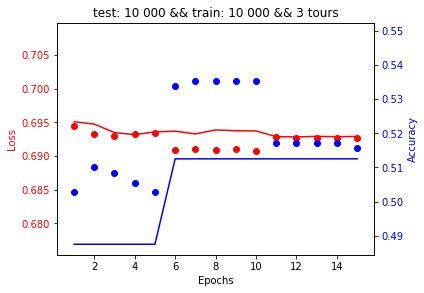

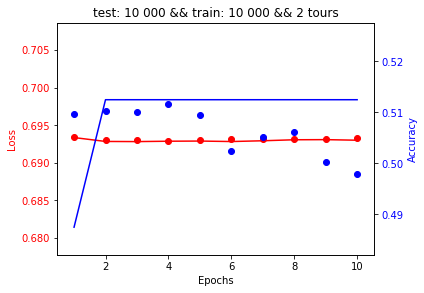

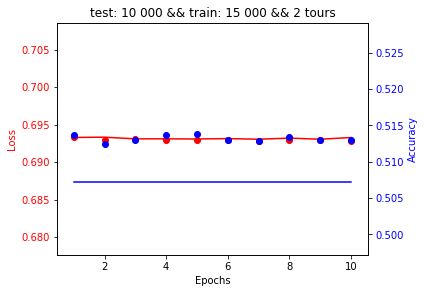

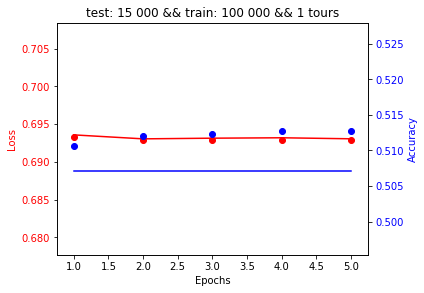

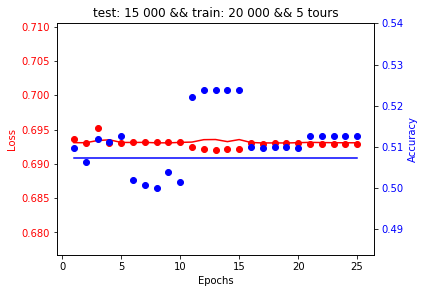

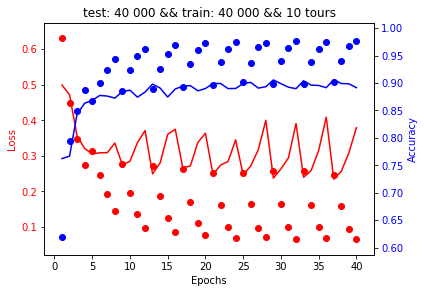

In [31]:
plotAllHist(
    [{'h': uh_1, 'title': 'test: 10 000 && train: 10 000 && 3 tours', 'save': True, 'name': '1' },
     {'h': uh_2, 'title': 'test: 10 000 && train: 10 000 && 2 tours', 'save': True, 'name': '2'},
     {'h': uh_3, 'title': 'test: 10 000 && train: 15 000 && 2 tours', 'save': True, 'name': '3' },
     {'h': uh_4, 'title': 'test: 15 000 && train: 100 000 && 1 tours', 'save': True, 'name': '4'},
     {'h': uh_5, 'title': 'test: 15 000 && train: 20 000 && 5 tours' , 'save': True, 'name': '5'},
     {'h': uh_6, 'title': 'test: 40 000 && train: 40 000 && 10 tours', 'save': True, 'name': '6'}
    ])